# Notebook for CRN4

This notebook can be used to generate data on the bursting gene chemical reaction.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib.pyplot as plt

import neuralnetwork
import convert_csv
import plot
import save_load_MDN

import pandas as pd
from scipy.stats import poisson

from CRN4_bursting_gene import propensities_bursting_gene as propensities

## Import data

In [2]:
FILE_NAME = 'data'
CRN_NAME = 'bursting_gene'
NUM_PARAMS = 4
NAME = 'Bursting Gene CRN'

Error in data: Inputs have 4 parameters but only the 1st one counts.

In [3]:
# loading data
X_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train1.csv')
X_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train2.csv')
X_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train3.csv')

y_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train1.csv')
y_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train2.csv')
y_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train3.csv')

X_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid1.csv')
X_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid2.csv')
X_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid3.csv')

y_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid1.csv')
y_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid2.csv')
y_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid3.csv')

X_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_test.csv')
y_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_test.csv')

train_data1 = [X_train1, y_train1]
valid_data1 = [X_valid1, y_valid1]
train_data2 = [X_train2, y_train2]
valid_data2 = [X_valid2, y_valid2]
train_data3 = [X_train3, y_train3]
valid_data3 = [X_valid3, y_valid3]

## Hyperparameters

In [12]:
LR = 0.005
N_ITER = 300
N_HIDDEN = 256
BATCHSIZE = 64
MIXTURE = 'NB'

## Choosing number of components - Elbow method

We use the elbow method to choose the appropriate number of components.

Computed loss with 1 components - average loss = 0.018296210716168087.
Computed loss with 2 components - average loss = 0.011601767192284266.
Computed loss with 3 components - average loss = 0.0073825108508268995.
Computed loss with 4 components - average loss = 0.006928345188498497.
Computed loss with 5 components - average loss = 0.006901857132713.
Computed loss with 6 components - average loss = 0.006864899769425392.


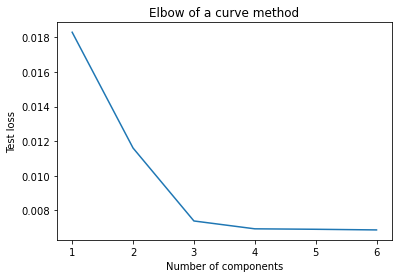

In [40]:
n_comps = np.arange(1, 7)
losses = []
for n in n_comps:
    loss = 0
    for _ in range(3):
        model = neuralnetwork.NeuralNetwork(n_comps=n, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE, print_info=False)
        neuralnetwork.train_NN(model, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE, print_results=False, print_info=False)
    loss += neuralnetwork.mean_loss(X_test, y_test, model, loss=neuralnetwork.loss_hellinger).detach().item()
    losses.append(loss/3)
    print(f'Computed loss with {n} components - average loss = {loss/3}.')
plt.plot(n_comps, losses)
plt.xlabel('Number of components')
plt.ylabel('Test loss')
plt.title('Elbow of a curve method')
plt.show()

In [41]:
N_COMPS = 4

## Training models

We train 3 different models to compare their accuracy.

In [42]:
model1 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model2 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model3 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [43]:
train_losses1, valid_losses1 = neuralnetwork.train_NN(model1, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses2, valid_losses2 = neuralnetwork.train_NN(model2, train_data2, valid_data2, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses3, valid_losses3 = neuralnetwork.train_NN(model3, train_data3, valid_data3, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)

Training ...: 100%|█████████▉| 299/300 [03:02<00:00,  1.64it/s]


Learning rate: 1.3707658621964214e-07,
Train loss: 0.001696216408163309,
 Valid loss: 0.00174470036290586


Training ...:  51%|█████     | 152/300 [01:36<01:34,  1.57it/s]


Learning rate: 0.0024476439502916078,
Train loss: 0.0023376576136797667,
 Valid loss: 0.002372163813561201


Training ...: 100%|█████████▉| 299/300 [02:59<00:00,  1.67it/s]

Learning rate: 1.3707658621964214e-07,
Train loss: 0.0018255844479426742,
 Valid loss: 0.0018490524962544441


In [44]:
for i, model in enumerate([model1, model2, model3]):
    save_load_MDN.save_MDN_model(model, f'CRN4_model{i+1}_comps4.pt')

In [49]:
model1 = save_load_MDN.load_MDN_model('saved_models_4comps/CRN4_model1_comps4.pt')
model2 = save_load_MDN.load_MDN_model('saved_models_4comps/CRN4_model2_comps4.pt')
model3 = save_load_MDN.load_MDN_model('saved_models_4comps/CRN4_model3_comps4.pt')

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [50]:
# Compute losses

print("Training dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_train3, y_train3, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_train3, y_train3, model3, loss=neuralnetwork.loss_hellinger)}')

print("\nValidation dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_valid3, y_valid3, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_valid3, y_valid3, model3, loss=neuralnetwork.loss_hellinger)}')

print("\nTest dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_hellinger)}')


Training dataset
KLD : 0.0018255844479426742
Hellinger : 0.02082422561943531

Validation dataset
KLD : 0.0018490524962544441
Hellinger : 0.02095748484134674

Test dataset
KLD : 0.0018817202653735876
Hellinger : 0.021089866757392883


## Distributions plot


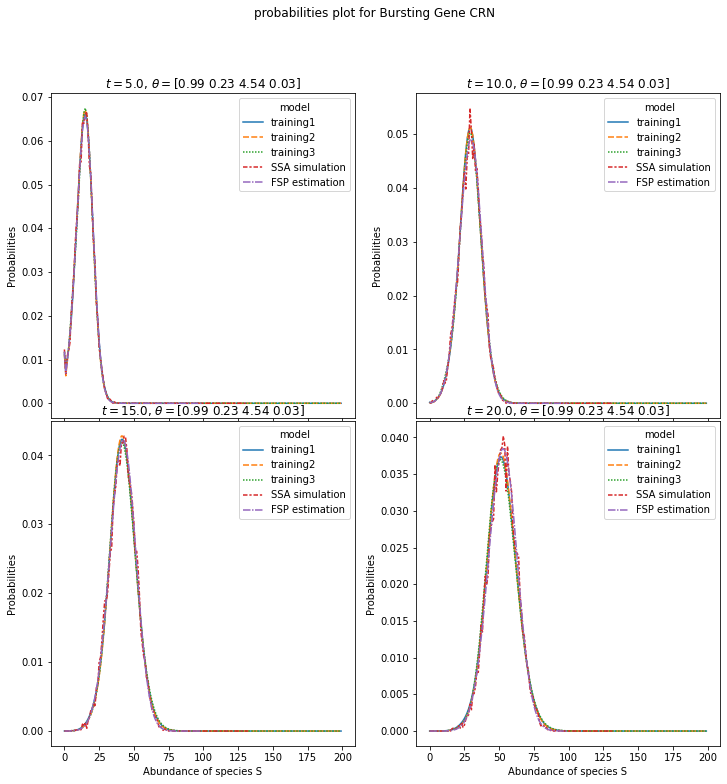

In [51]:
plot.multiple_plots(to_pred=[X_test[20+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = 4*[200], 
                    n_comps=N_COMPS,
                    plot_test_result=(True, [y_test[20+k,:] for k in range(4)]), 
                    plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                    save=(False, '4distributions_2.png'),
                    crn_name=NAME)

Training ...:  54%|█████▍    | 272/500 [3:57:22<3:18:58, 52.36s/it]


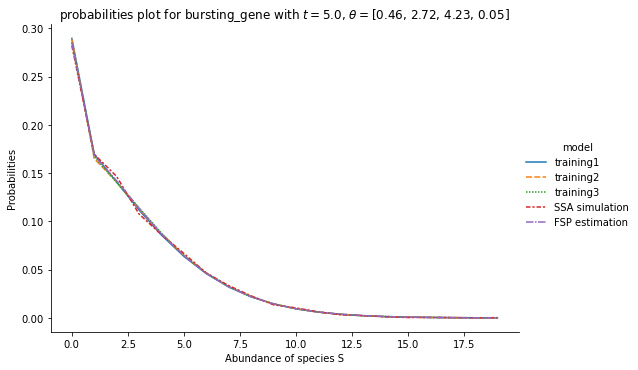

In [52]:
index = 0
plot.plot_model(to_pred=X_test[index,:], 
                models=[model1, model2, model3], 
                up_bound=20,
                n_comps=N_COMPS,
                plot_test_result=(True, y_test[index, :]),
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                crn_name=CRN_NAME)

We can check the accuracy for higher times than those of the training:

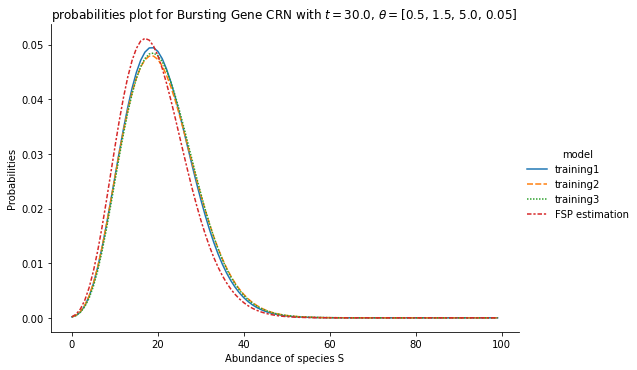

In [53]:
plot.plot_model(to_pred=torch.tensor([30., 0.5, 1.5, 5., 0.05]),
                models=[model1, model2, model3], 
                up_bound = 100,
                n_comps=N_COMPS,
                confidence_interval=False, 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                save=(False, 't50kon4koff13.png'),
                crn_name=NAME)

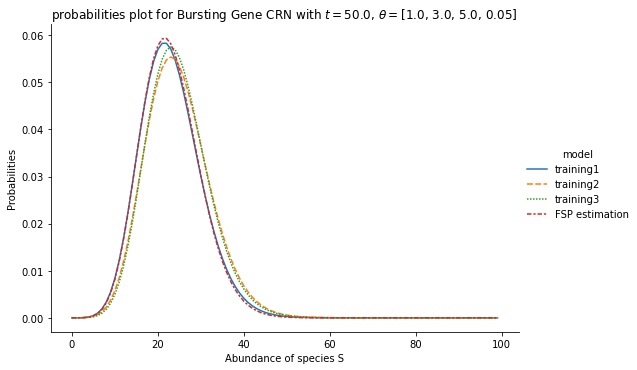

In [55]:
# alpha = 80
plot.plot_model(to_pred=torch.tensor([50., 1, 3, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound = 100, 
                n_comps=N_COMPS,
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                confidence_interval=False,
                crn_name=NAME)

We can also check the accuracy for parameters outside the bounds of the training.

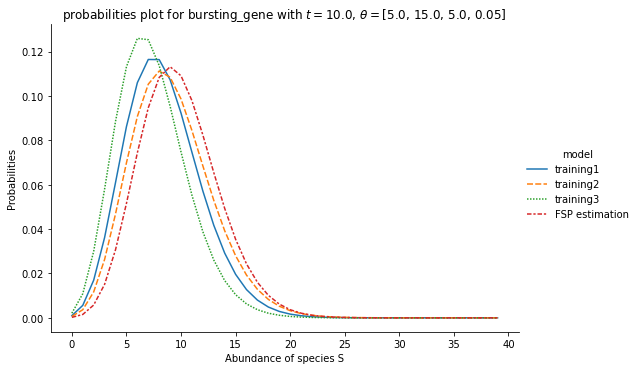

In [56]:
# alpha = 100
plot.plot_model(to_pred=torch.tensor([10., 5., 15, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound = 40, 
                n_comps=N_COMPS,
                confidence_interval=False, 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                save=(False, 't10kon5koff15'),
                crn_name=CRN_NAME)

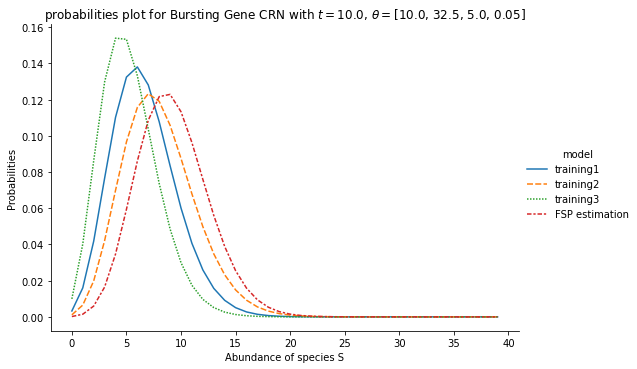

In [57]:
# alpha = 200
plot.plot_model(to_pred=torch.tensor([10., 10., 32.5, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound=40, 
                n_comps=N_COMPS,
                confidence_interval=False, 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                save=(False, 't10kon10koff32demi.png'),
                crn_name=NAME)

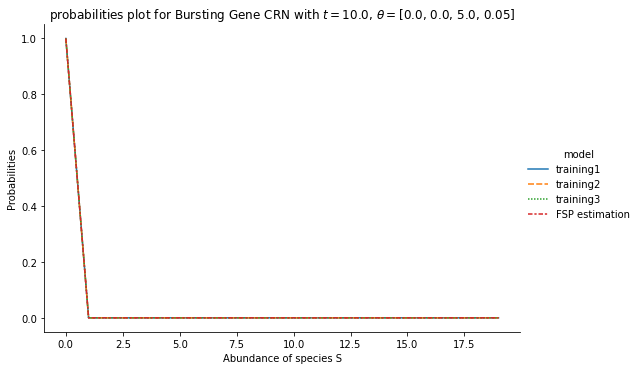

In [58]:
plot.plot_model(to_pred=torch.tensor([10., 0.05*1e-3, 0.15*1e-3, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                save=(False, 't10kon005e-3koff015e-3.png'),
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                crn_name=NAME)

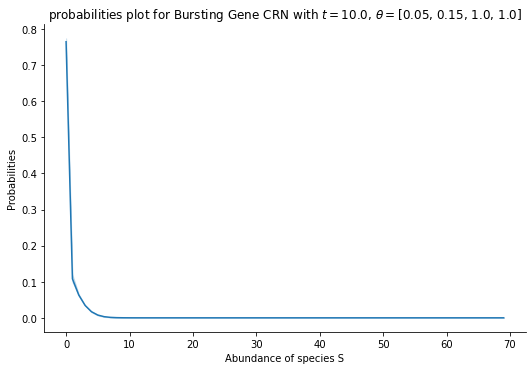

In [59]:
plot.plot_model(to_pred=torch.tensor([10., 0.05, 0.15, 1., 1.]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                confidence_interval=True,
                crn_name=NAME)

## Sentivities plot

To compute sensitivities and compare them to the theoretical ones. 

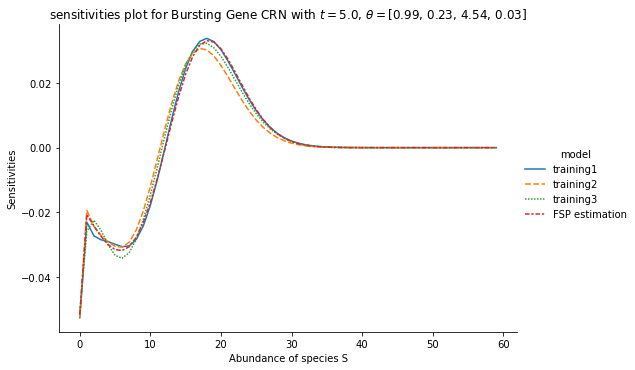

In [60]:
plot.plot_model(to_pred=X_test[20], 
                models=[model1, model2, model3], 
                up_bound=60, 
                n_comps=N_COMPS,
                plot=('sensitivities', 0), 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                index_names = ('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_t15kon47koff14.png'),
                crn_name=NAME)

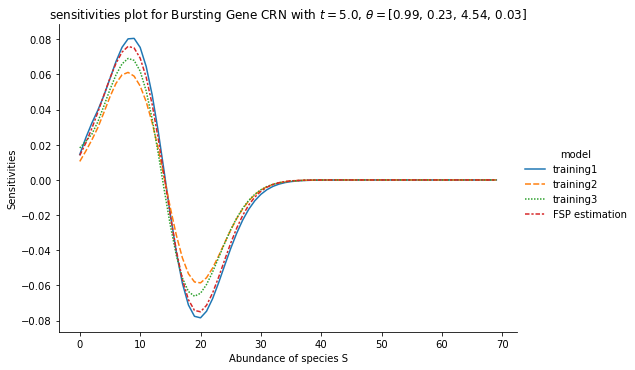

In [61]:
plot.plot_model(to_pred=X_test[20], 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 1), 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                confidence_interval=False, 
                index_names=('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_koff_t15kon47koff14.png'),
                crn_name=NAME)

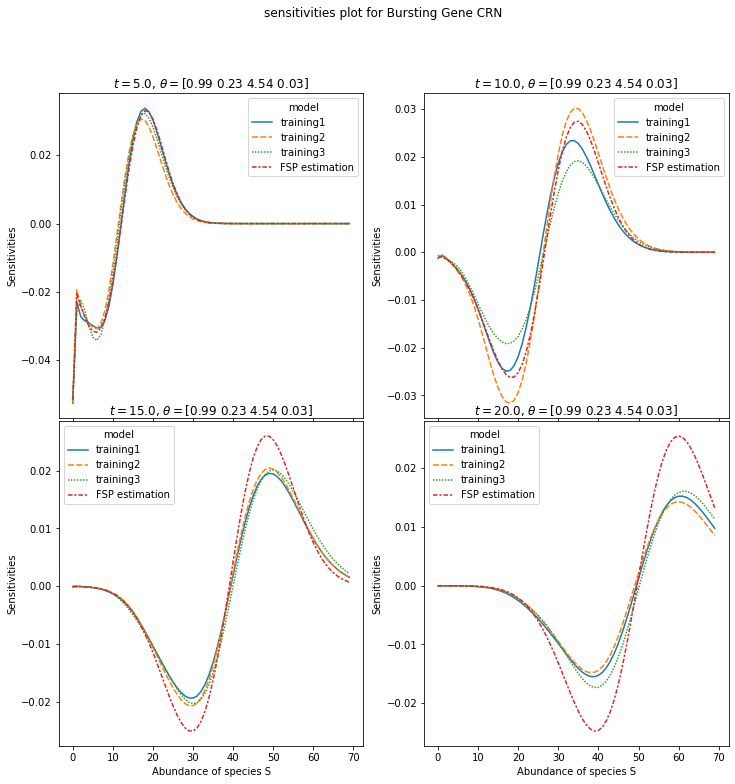

In [62]:
plot.multiple_plots(to_pred=[X_test[20+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [70]*5, 
                    n_comps=N_COMPS,
                    plot=('sensitivities', 0), 
                    plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                    index_names=('Sensitivities', 'Abundance of species S'),
                    save=(False, 'sensitivities_kon.png'),
                    crn_name=NAME)

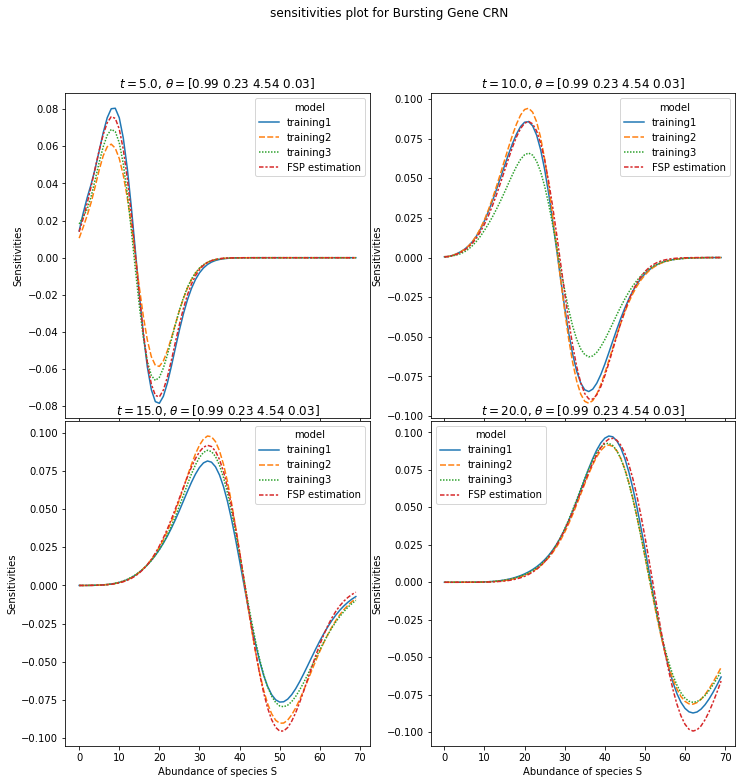

In [63]:
plot.multiple_plots(to_pred=[X_test[20+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [70]*5, 
                    n_comps=N_COMPS,
                    plot=('sensitivities', 1), 
                    plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                    index_names=('Sensitivities', 'Abundance of species S'),
                    save=(False, 'sensitivities_kon.png'),
                    crn_name=NAME)

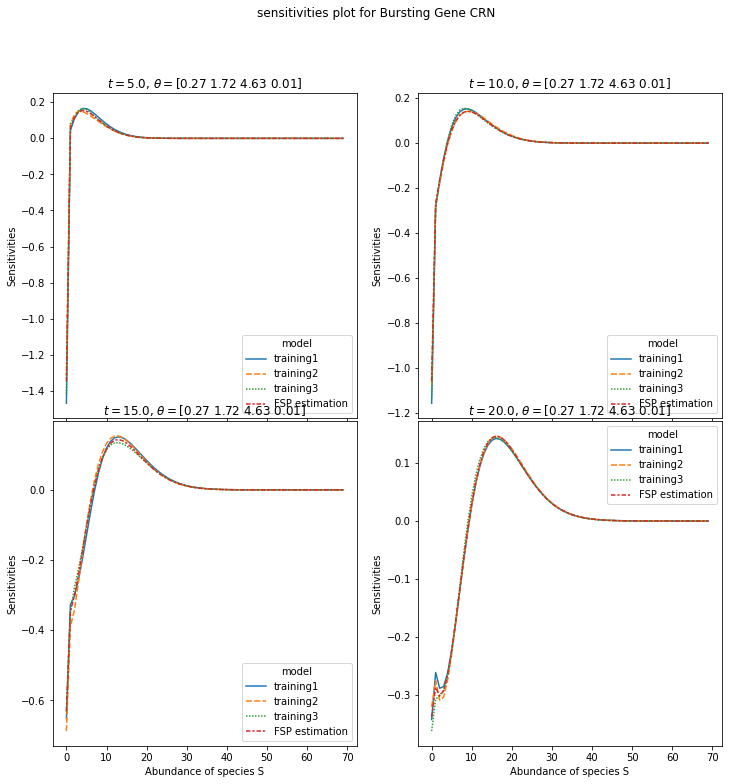

In [64]:
plot.multiple_plots(to_pred=[X_test[992+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [70]*5, 
                    n_comps=N_COMPS,
                    plot=('sensitivities', 0), 
                    plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                    index_names=('Sensitivities', 'Abundance of species S'),
                    save=(False, 'sensitivities_kon.png'),
                    crn_name=NAME)

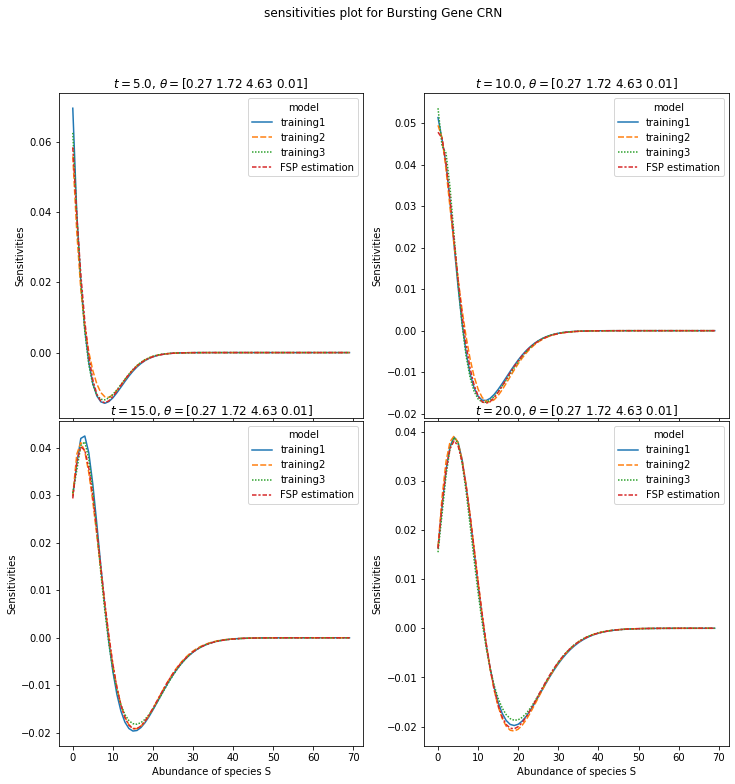

In [65]:
plot.multiple_plots(to_pred=[X_test[992+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [70]*5, 
                    n_comps=N_COMPS,
                    plot=('sensitivities', 1), 
                    plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                    index_names=('Sensitivities', 'Abundance of species S'), 
                    save=(False, 'sensitivities_koff.png'),
                    crn_name=NAME)

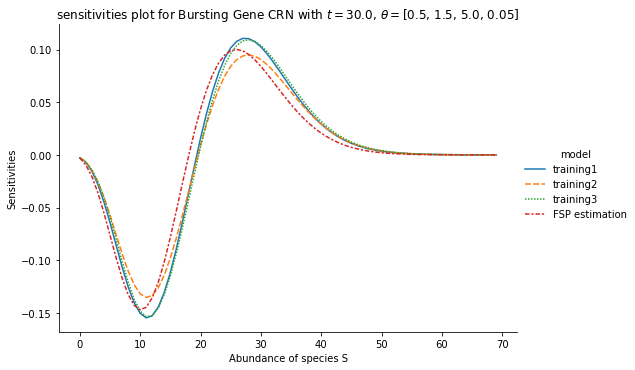

In [66]:
# alpha=10
plot.plot_model(to_pred=torch.tensor([30, 0.5, 1.5, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 0), 
                confidence_interval=False, 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                index_names=('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_kon_thigher.png'),
                crn_name=NAME)

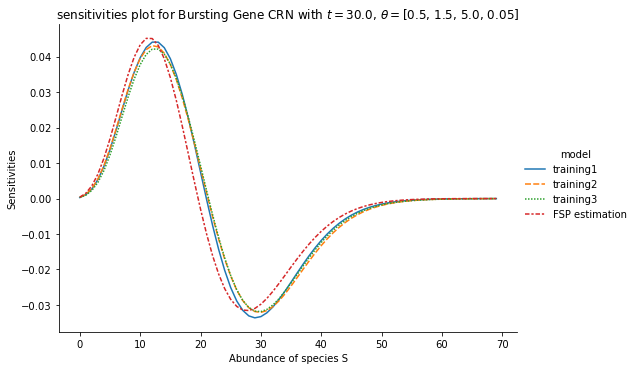

In [67]:
plot.plot_model(to_pred=torch.tensor([30, 0.5, 1.5, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 1), 
                confidence_interval=False, 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                index_names = ('Sensitivities', 'Abundance of species S'),
                save=(False, 'sensitivities_koff_thigher.png'),
                crn_name=NAME)

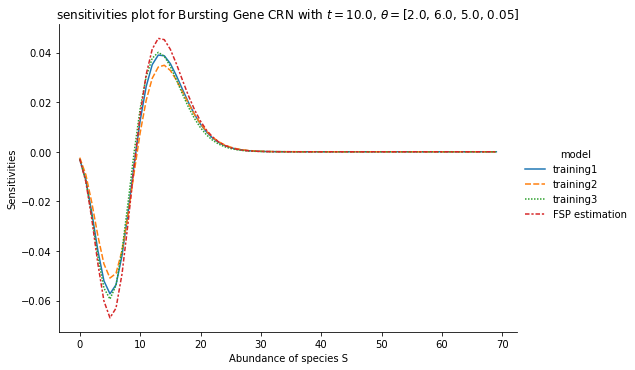

In [68]:
# alpha=40
plot.plot_model(to_pred=torch.tensor([10, 2, 6, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 0), 
                confidence_interval=False, 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                index_names=('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_kon_alphahigher.png'),
                crn_name=NAME)

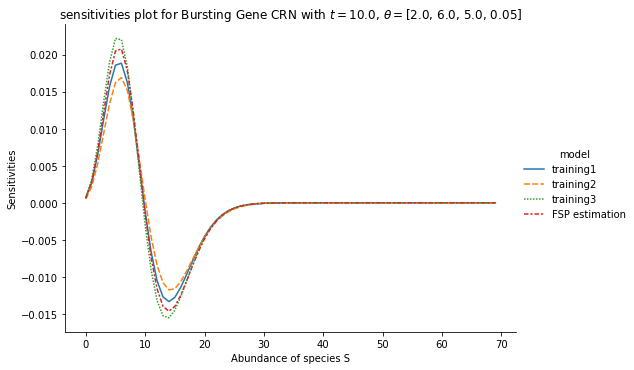

In [69]:
# alpha=40
plot.plot_model(to_pred=torch.tensor([10, 2, 6, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70,
                n_comps=N_COMPS, 
                plot=('sensitivities', 1), 
                confidence_interval=False, 
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
                index_names=('Sensitivities', 'Abundance of species S'),
                save=(False, 'sensitivities_koff_alphahigher.png'),
                crn_name=NAME)

## Fisher information

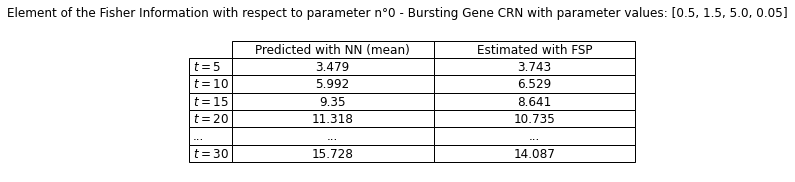

In [70]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30], 
            params=[0.5, 1.5, 5., 0.05], 
            ind_param=0, 
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp=(True, propensities.stoich_mat, propensities.propensities, 200, None, 1),
            crn_name=NAME,
            out_of_bounds_index=4)

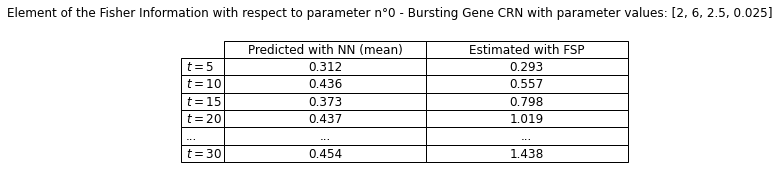

In [71]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30], 
            params=[2, 6, 2.5, 0.025], 
            ind_param=0, 
            models=(True, [model1, model2, model3], N_COMPS),
            plot_fsp=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
            crn_name=NAME,
            out_of_bounds_index=4)

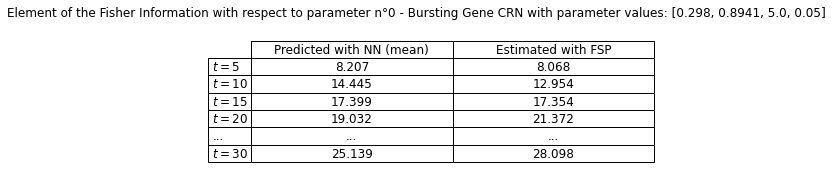

In [72]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30], 
            params=[0.298, 0.8941, 5., 0.05], 
            ind_param=0, 
            models=(True, [model1, model2, model3], N_COMPS),
            plot_fsp=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
            crn_name=NAME,
            out_of_bounds_index=4)

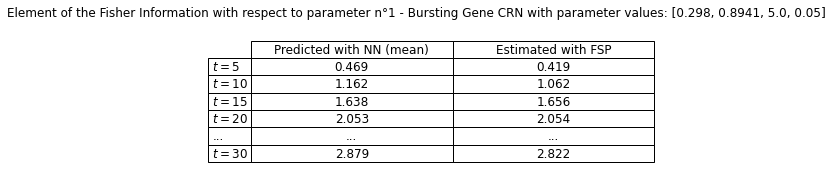

In [73]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30], 
            params=[0.298, 0.8941, 5., 0.05], 
            ind_param=1, 
            models=(True, [model1, model2, model3], N_COMPS),
            plot_fsp=(True, propensities.stoich_mat, propensities.propensities, 100, None, 1),
            crn_name=NAME,
            out_of_bounds_index=4)